# Modelo de Prediccion de Imagenes


## Cargar Librerias

In [3]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score

## 2.1 Cargar Datos

Cargamos la base de datos caltech-101 desde un directorio local

In [2]:
# Directorio donde se encuentran las imágenes
data_dir = 'D:\\U\\7. Septimo\\RI\\ir24a\\week14\\caltech-101'

In [3]:
# Cargar las imágenes desde el directorio

# Se usa para cargar las imágenes de training
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training", 
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Se usa para cargar las imágenes de test
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="validation", 
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 9144 files belonging to 102 classes.
Using 7316 files for training.
Found 9144 files belonging to 102 classes.
Using 1828 files for validation.


Si el total de imágenes en tu dataset es 𝑋, entonces:
- El conjunto de entrenamiento tendrá 0.8𝑋 imágenes.
- El conjunto de prueba/validación tendrá 0.2𝑋 imágenes.

Por lo que especificamente se tendria: 
Total de imágenes 
𝑋 ≈ 7316 + 1828 = 9144
- Conjunto de entrenamiento: 0.8 × 9144 ≈ 7316 imágenes.
- Conjunto de prueba/validación: 0.2 × 9144 ≈ 1828 imágenes.

## 2.2 Preprocesamineto de las imagenes

Usamos las librerias VGG16 y tensorflow.keras.models

In [4]:
# Obtener el número de clases
class_names = train_dataset.class_names
num_classes = len(class_names)

In [5]:
# Preprocesar las imágenes 
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Aplicar la función de preprocesamiento a los datasets
train_dataset = train_dataset.map(preprocess_image)
test_dataset = test_dataset.map(preprocess_image)

## 2.3 Extraccion de Caracteristicas


In [6]:
# Cargar el modelo VGG16 con pesos preentrenados
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Crear un nuevo modelo que produzca los mapas de características
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [7]:
# Función para extraer características
def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [8]:
# Extraer características para los conjuntos de datos de entrenamiento y prueba
train_features, train_labels = extract_features(train_dataset)
test_features, test_labels = extract_features(test_dataset)

1/1 [==============================] - 1s 1s/step


## 2.4 Indexacion

In [9]:
# Crear un índice usando k-NN
knn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(train_features.reshape(train_features.shape[0], -1))


## 2.5 Motor de Búsqueda

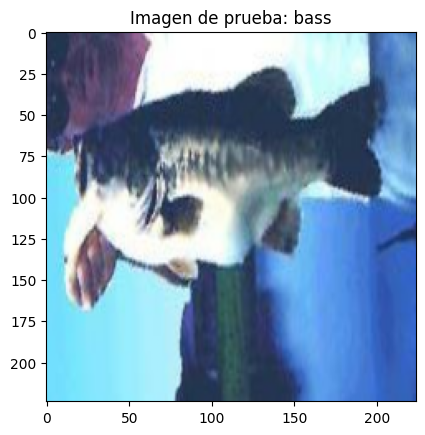

In [10]:
def search_image(query_image, knn_index, k=5):
    query_features = model.predict(query_image[np.newaxis, ...])
    distances, indices = knn_index.kneighbors(query_features.reshape(1, -1), n_neighbors=k)
    return indices[0], distances[0]  # Devolvemos también las distancias

# Tomar una imagen de prueba como ejemplo
for images, labels in test_dataset.take(1):
    query_image = images[11]
    query_label = labels[11]  # Almacenar la etiqueta de la imagen de prueba

# Mostrar la imagen seleccionada para la prueba
plt.imshow(query_image.numpy())
plt.title(f'Imagen de prueba: {class_names[query_label]}')
plt.show()

In [11]:
# Realizar la búsqueda
indices, distances = search_image(query_image, knn)
# Imprimir resultados
print("Índices de las imágenes más similares:", indices)
print("Distancias a las imágenes más similares:", distances)

1/1 [==============================] - 0s 144ms/step
Índices de las imágenes más similares: [5960 1729 4384 6484 6031]
Distancias a las imágenes más similares: [44.41160351 44.57408733 45.19488827 45.20776755 45.28253675]


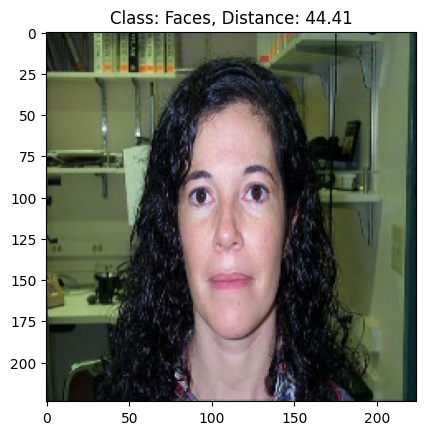

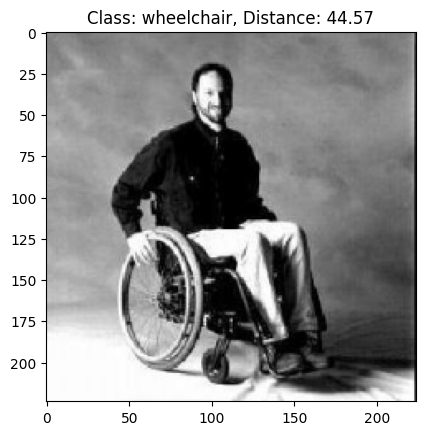

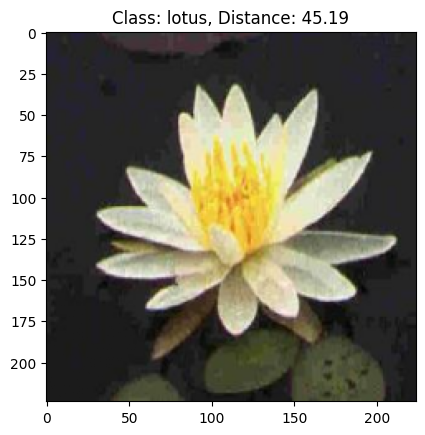

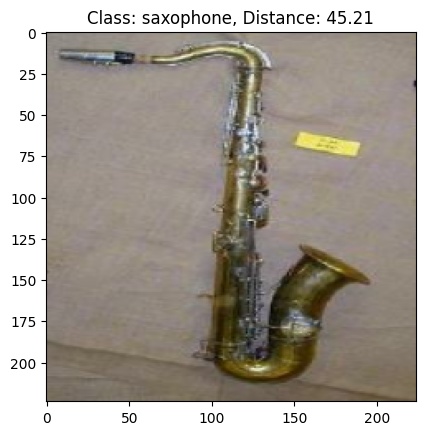

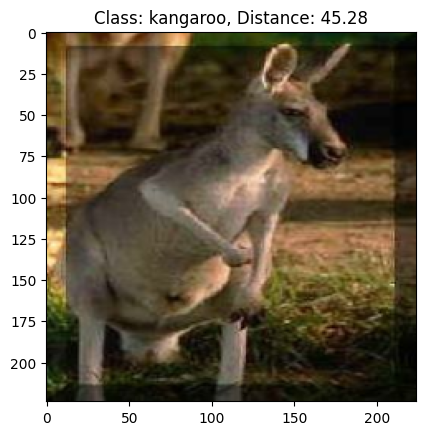

In [12]:
# Mostrar las imágenes más similares
for idx, dist in zip(indices, distances):
    similar_image = train_dataset.unbatch().skip(idx).take(1)
    for image, label in similar_image:
        plt.imshow(image.numpy())
        plt.title(f'Class: {class_names[label]}, Distance: {dist:.2f}')
        plt.show()

## 2.7 Evaluación del Sistema

In [13]:
def evaluate_system(test_features, test_labels, knn_index):
    y_true = []
    y_pred = []
    for i in range(len(test_features)):
        query_features = test_features[i]
        distances, indices = knn_index.kneighbors(query_features.reshape(1, -1), n_neighbors=1)
        y_true.append(test_labels[i])
        y_pred.append(train_labels[indices[0][0]])
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return precision, recall, f1

precision, recall, f1 = evaluate_system(test_features, test_labels, knn)
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

Precision: 0.694637965229678, Recall: 0.5835698058203198, F1-Score: 0.5918703364723703


c:\Users\matte\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
#Guardar el modelo utilizado para la extracción de características en un archivo .h5
model.save('modelo.h5')

NameError: name 'model' is not defined